_This is not finished. It does not properly handle a diffuse lower boundary yet, as was introduced in the 2019 paper._

_This may generally work but the `fsolve` doesn't converge for Venus parameters which I do not understand. Perhaps it would be better to use `scipy.optimize.root`? Or perhaps I have implemented the model incorrectly._



## Analytic Radiative-Convective Model

This notebook is about the analytic radiative-convective model defined in [Robinson and Catling (2012)](https://iopscience.iop.org/article/10.1088/0004-637X/757/1/104/meta) and further developed in [Robinson and Catling (2014)](http://faculty.washington.edu/dcatling/Robinson2014_0.1bar_Tropopause.pdf) and [Tolento and Robinson (2019)](https://www.sciencedirect.com/science/article/pii/S0019103518305098?casa_token=bLl29eAPT2MAAAAA:jwepgUN4mTHwRxJe3g8oOBriBHYs2h2VgLGlk04b1M_-Io7P14W3dQhiIgfyAPbCdHtP7cZuR2Q).

It consists of the following components/assumptions:

1. The atmosphere is grey to longwave radiation and is parameterised via the optical depth $\tau$ which related to pressure via $\tau = \tau_0 \left( \frac{p}{p_0}\right)^n$, where $\tau_0$ is the atmosphere's total optical thickness, $p_0$ is the surface pressure and $n$ is a parameter which is typically between $1$ and $2$ and determined for each planet based on observations and related reasoning.
2. A convective region which stretches from the surface to a radiative-convective boundary in which the lapse rate is a function of the optical depth via the pressure:

$$ 
T = T_0 \left( \frac{\tau}{\tau_0}\right)^{\beta/n}
$$

where $\beta = \alpha(\gamma -1)/\gamma$ with $\gamma$ is the ratio of specific heats (so depends on the degrees of freedom of the major atmospheric constituents) and $\alpha$ is a parameter (chosen to fit observation) which adjusts the lapse rate away from the dry lapse rate to account for latent heat release during convection.

3. Solar radiation is parameterised in two channels, with a portion of the solar radiation being absorbed in what becomes the stratosphere, and a portion penetrating to the troposphere and surface:

$$
 F^{\odot}(\tau) = \alpha \left( F_1^\odot e^{-k_1 \tau} + F_2^\odot e^{-k_2 \tau}\right)
$$

Again, the amoung of radiation in each channel, $F_1$ and $F_2$ and the strength of the attenuation (in terms of the longwave optical depth) $k_1$ and $k_2$ are chosen to fit observations.


The model is solved by requiring continuity in the upwards energy flux and the temperature throughout the atmosphere, particularly at the radiative-convective boundary, below which the temperature profile is determiend explicitly by the first equation above and above which the temperature profile is a result of a balance between absorbed shortwave and net longwave absorbed and emitted. These are two conditions and so the model can be solved for two unknowns, which might be surface temperature and the height of the radiative-convective boundary, or perhaps total optical depth and the height of the radiative convective boundary (with surface temperature fixed), depending on the needs of the situation.

The simplicity of the grey atmosphere allows the temperature and radiative fluxes in the radiative-only upper region to be solved for analytically as a function of the solar radiation and upwelling radiation from the convective region via the Schwarzchild equations for radiation in a plane-parallel atmospehre. Similarly, the radiation in the convective region (where the temperature profile is prescribed) can be solved for analytically, though the solution involves the upper incomplete gamma function. The continuity is then achieved by adjusting the two free parameters until the temperature and upwards radiation flux at the boundary between the two regions matches. This is done numerically, here by `scipy.optimize.fsolve`.

In this notebook, further free parameter sets are explored, so that surface temperature and optical thickness can be specified, for example, and the shortwave albedo adjusted to satisfy these conditions, or the moisture content of the atmosphere.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.special import gamma
from scipy.special import gammainc  #lower regularized
from scipy.special import gammaincc  #upper regularized (=1/gamma(a) * gammaincomplete(a,x))

import mpmath as mp
import scipy.constants as const

## (1) Prescribe Planet's Parameters.

The model can only be solved with respect to two free parameters and so the rest of the parameters must be determined by observation and deduction. These have been tabulated in Tolento and Robinson (2019), Table 1, for example.


In [2]:
# Earth Parameters
 
earth = {'D':    1.66,        #diffusivity factor (see, e.g., Rodgers & Walshaw 1966)
        'T_sun': 5779,        # K
        'gam':   1.4,         #ratio of specific heats, cp/cv
        'n':     2,           #power for optical depth - pressure scaling (tau~p^n)
         
         
        'Fi':    0,           #internal heat flux [W/m**2]
        'F1':    7,
        'F2':    233,
        'k1':    90,
        'k2':    0.16,
         
        'alpha': 0.6,         #adjustment to dry adiabatic lapse rate
        
        'tau0':  1.9,
        'T0':    288,
        'taurc': 0.15 ,        
        #Additional parameter for plotting, not for solving the model.
        'p0':    1,            #surface pressure [atm]
        'heat_cap': 1005      #J/kgC, from Houghton page 275
    
        }

# These are the venus parameters from the 2019 paper.
venus = {'D':    1.66,        #diffusivity factor (see, e.g., Rodgers & Walshaw 1966)
        'T_sun': 5779,        # K
        'gam':   1.3,         #ratio of specific heats, cp/cv
        'n':     1,           #power for optical depth - pressure scaling (tau~p^n)
         
         
        'Fi':    0,           #internal heat flux [W/m**2]
        'F1':    110,
        'F2':    46,
        'k1':    0.518,
        'k2':    9*10**-4,
         
        'alpha': 0.8,         #adjustment to dry adiabatic lapse rate
        
        'tau0':  990,
        'T0':    730,
        'taurc':  20,
         
        #Additional parameter for plotting, not for solving the model.
        'p0':    92.1,            #surface pressure [atm]
        'heat_cap': 1000      #J/kgC, !! very approximate.

        }

venus_2012 = {'D':    1.66,        #diffusivity factor (see, e.g., Rodgers & Walshaw 1966)
        'T_sun': 5779,        # K
        'gam':   1.3,         #ratio of specific heats, cp/cv
        'n':     1,           #power for optical depth - pressure scaling (tau~p^n)
         
         
        'Fi':    0,           #internal heat flux [W/m**2]
        'F1':    0,
        'F2':    160,
        'k1':    0.518,
        'k2':    9*10**-4,
         
        'alpha': 0.8,         #adjustment to dry adiabatic lapse rate
        
        'tau0':  400,
        'T0':    730,
        'taurc':  1,
         
        #Additional parameter for plotting, not for solving the model.
        'p0':    92.1,            #surface pressure [atm]
        'heat_cap': 1000      #J/kgC, !! very approximate.

        }


neptune = {'D':    1.66,        #diffusivity factor (see, e.g., Rodgers & Walshaw 1966)
        'T_sun': 5779,        # K
        'gam':   1.4,         #ratio of specific heats, cp/cv
        'n':     2,           #power for optical depth - pressure scaling (tau~p^n)
         
         
        'Fi':    0.43,           #internal heat flux [W/m**2]
        'F1':    0.09,
        'F2':    0.18,
        'k1':    580,
        'k2':    0.2,
         
        'alpha': 0.87,         #adjustment to dry adiabatic lapse rate
        
        'tau0': 3.0,
        'T0':    72,
        'taurc':  0.42,
         
        #Additional parameter for plotting, not for solving the model.
        'p0':    1,            #surface pressure [atm]
        'heat_cap': 1000      #J/kgC, !! very approximate.

        }


## (2) Formulate the continuity conditions.

The model is solved when the free parameters allow continuity of temperature and upwelling thermal flux across between the convective and radiative-only regions. The continuity function `ContinuityConditions()` simply returns the difference, which is then minimised by `fsolve` in `Solve()`.

In [3]:
def ContinuityConditions(X, item, freevar = 'taurcT0'):
    # X is a vector with the two free parameters.
    # item is a dictionary with the parameters of the atmosphere.
    # freevar selects which free parameters are being solved for in this case. It is possible to different sets of parameters, provided only two are left to be solved for.
    
    p0 = item['p0']
    Fi = item['Fi']
    k1 = item['k1']
    k2 = item['k2']
    D = item['D']
    gam = item['gam']
    n = item['n']
    
    sigma = const.sigma
    
    if freevar == 'taurcT0':
        T0 = X[1]
        taurc = X[0] 
        
        F1 = item['F1']
        F2 = item['F2']
        alpha = item['alpha']
        beta = alpha*(gam - 1.)/gam
        tau0 = item['tau0']
        
    elif freevar == 'taurctau0':
        taurc = X[0]
        tau0 = X[1]
        alpha = item['alpha']
        T0 = item['T0']
        F1 = item['F1']
        F2 = item['F2']
        beta = alpha*(gam - 1.)/gam 
        
    elif freevar == 'taurcalpha':
        taurc = X[0]
        alpha = X[1]
        tau0 = item['tau0']
        T0 = item['T0']
        F1 = item['F1']
        F2 = item['F2']
        beta = alpha*(gam - 1.)/gam 
        
    else:
        print("That's not a permitted free variable.")

    
    if np.min([taurc, tau0])<0:
        # this is a non-physical case, so give it a high cost.
        print('Negative tau0 or taurc.')
        return (1e6, 1e6)
    if tau0<taurc:
        # this is a non-physical case, so give it a high cost.
        print('tau0 < taurc.')
        return (1e6, 1e6)
    else:
         # Upwelling thermal flux at R-C boundary from radiative equilibrium (RC12 Eq. 19)
        Fup_r = F1/2*(1 + D/k1 + (1 - D/k1)*np.exp(-k1*taurc)) + \
                    F2/2*(1 + D/k2 + (1 - D/k2)*np.exp(-k2*taurc)) + \
                    Fi/2*(2 + D*taurc)
        # Temperature at R-C boundary from radiative equilibrium (RC12 Eq. 18)
        sigmaT_r = F1/2*(1 + D/k1 + (k1/D - D/k1)*np.exp(-k1*taurc)) + \
                 F2/2*(1 + D/k2 + (k2/D - D/k2)*np.exp(-k2*taurc)) + \
                 Fi/2*(1 + D*taurc)
        T_r = (sigmaT_r/sigma)**0.25
        
    
    # Upwelling thermal flux at R-C boundary from convective region (RC12 Eq. 13)
    Fup_c = sigma*T0**4*np.exp(D*taurc)*(np.exp(-D*tau0) + \
            1/(D*tau0)**(4*beta/n)*gamma(1+4*beta/n)*(gammainc(1+4*beta/n,D*tau0) - \
                                                     gammainc(1+4*beta/n,D*taurc)))

    # Temperature at R-C boundary from convective region (RC12 Eq. 11)
    T_c = T0*(taurc/tau0)**(beta/n)
    
    return (T_r - T_c, Fup_r - Fup_c) 

In [4]:
def Solve(item, freevar = 'taurcT0'):

    if freevar == 'taurcT0':
        X =  fsolve(lambda x:ContinuityConditions(x, item, freevar=freevar), x0 = [.2,280], maxfev = 5000)
        item['taurc'] = X[0] 
        item['T0'] = X[1] 
        
    elif freevar == 'taurctau0':
        X =  fsolve(lambda x:ContinuityConditions(x, item, freevar=freevar), x0 = [item['taurc'],item['tau0']], maxfev = 5000, )
        item['taurc'] = X[0] 
        item['tau0'] = X[1] 
        
    elif freevar == 'taurcalpha':
        X =  fsolve(lambda x:ContinuityConditions(x, item, freevar=freevar), x0 = [.2,0.6], maxfev = 5000)
        item['taurc'] = X[0] 
        item['alpha'] = X[1]
        
    else:
        print('That is not an allowed freevar option.')
    return item

## (3) Add additional information for plotting and plotting function.

In [5]:
def AddFluxes(item):
    
    p0 = item['p0']
    tau0 = item['tau0']

    Fi = item['Fi']
    k1 = item['k1']
    k2 = item['k2']
    D = item['D']
    alpha = item['alpha']
    gam = item['gam']
    n = item['n']
    beta = alpha*(gam - 1.)/gam
    T0 = item['T0']
    tau0 = item['tau0']
    taurc = item['taurc']

    F1 = item['F1']
    F2 = item['F2']
    
    
    sigma = const.sigma
    
    #Plot extent options
    taumin       = 1.e-8 #minimum value of optical depth, tau
    taumax       = tau0  #optical depth at reference pressure p0
    Nlvls        = 5000   #number of points
    tau = np.exp(np.linspace(np.log(taumin), np.log(taumax), num = Nlvls))

    # corresponding pressure grid
    p = p0*(tau/tau0)**(1/n)
    p_rc = p0*(taurc/tau0)**(1/n)

    #temperature profile, initialized to zero
    T     = p.copy()*0  #sets size and type of the temperature array equivalent to pressure array, initialize all temperatures to zero 
    Fupth = p.copy()*0 
    Fdnth = p.copy()*0 

    #temperature in radiative region (RC12 Eq. 18), which 
    #only applies for optical depths smaller than taurc (i.e., 
    #above the R-C boundary)

    sigmaT  = F1/2*(1 + D/k1 + (k1/D - D/k1)*np.exp(-k1*tau)) + F2/2*(1 + D/k2 + (k2/D - D/k2)*np.exp(-k2*tau)) + Fi/2*(1 + D*tau)

    iRAD    = np.where(tau <= taurc) #find the array subscripts for the radiative regime
    T[iRAD] = (sigmaT[iRAD]/sigma)**0.25 #set temperatures in the radiative regime

    #upwelling thermal flux (RC12 Eq. 19)
    Fupth[iRAD] = F1/2*(1 + D/k1 + (1 - D/k1)*np.exp(-k1*tau[iRAD])) + \
                    F2/2*(1 + D/k2 + (1 - D/k2)*np.exp(-k2*tau[iRAD])) + \
                    Fi/2*(2 + D*tau[iRAD])
    #downwelling thermal flux (RC12 Eq. 20)
    Fdnth[iRAD] = F1/2*(1 + D/k1 - (1 + D/k1)*np.exp(-k1*tau[iRAD])) + \
                    F2/2*(1 + D/k2 - (1 + D/k2)*np.exp(-k2*tau[iRAD])) + \
                    Fi/2 * D * tau[iRAD]

    #temperature in convective region (RC12 Eq. 11), which 
    #only applies for optical depths larger than taurc (i.e., 
    #below the R-C boundary)

    iCON    = np.where(tau > taurc)   #find the array subscripts for the convective regime
    T[iCON] = T0*(tau[iCON]/tau0)**(beta/n) #set temperatures in the convective regime

    #upwelling thermal flux (RC12 Eq. 13)
    Fupth[iCON] = sigma*T0**4*np.exp(D*tau[iCON])*(np.exp(-D*tau0) + \
                1/(D*tau0)**(4*beta/n)*gamma(1+4*beta/n)*(gammainc(1+4*beta/n,D*tau0) - \
                                                         gammainc(1+4*beta/n,D*tau[iCON])))

    #downwelling thermal flux (RC12 Eq. 14) is solved for analytically in Tolento(2019, Eq. 19)
    Fdnth_taurc = F1/2*(1 + D/k1 - (1 + D/k1)*np.exp(-k1*taurc)) + \
                    F2/2*(1 + D/k2 - (1 + D/k2)*np.exp(-k2*taurc)) + \
                    Fi/2 * D * taurc

    for i in iCON[0]:
        Fdnth[i] = Fdnth_taurc * np.exp(-D*(tau[i] - taurc)) + \
                ((sigma*T0**4*np.exp(-D*tau[i])) / ((D*tau0)**(4*beta/n)) \
                )*np.absolute((mp.gammainc(1+4*beta/n,a=-D*tau[i]) - mp.gammainc(1+4*beta/n,a=-D*taurc)))  #The mp.gammainc defaults to the upper 

    #net solar flux in both radiative and convective regions, 
    #computed from RC12 Eq. 15
    Fsol = F1*np.exp(-k1*tau) + F2*np.exp(-k2*tau) 

    #convective flux, computed from RC12 Eq. 22
    Fconv = Fsol - (Fupth - Fdnth)

    
    # Put the values back in item.
    item['tautp'] = tau[np.argmin(T)]
    item['Ttp'] = np.min(T)
    item['p_tp'] = p[np.argmin(T)]
    item['p_rc'] = p_rc
    item['tau'] = tau
    item['T'] = T
    item['p'] = p
    item['Fupth'] = Fupth
    item['Fdnth'] = Fdnth
    item['Fsol'] = Fsol
    item['Fconv'] = Fconv
    item['T_rc'] = T0*(taurc/tau0)**(beta/n)
    
    surf_transmittance = np.exp(-D*tau0)
    Fcts_surf = sigma*T0**4 * surf_transmittance
    
    transmittance = np.exp(-D*tau)

    layer_thickness = tau[1:]-tau[:-1]
    layer_T = (T[1:] + T[:-1])/2
    Fcts = (1-np.exp(-D*layer_thickness))*sigma*layer_T**4 * transmittance[:-1]
    
    
    ## Some extra items for plotting. The heating rates are for the layers between pressure levels.
    heat_cap = item['heat_cap']     #J/kgC, from Houghton page 275

    atmtopascal = 101325 # pascal per atm
    layer_mass = (item['p'][1:] - item['p'][:-1])*atmtopascal/const.g
    secday = 60*60*24
    
    
    item['hr_CTS'] = -Fcts*secday/(heat_cap*layer_mass)
    item['hr_intrad'] = ((Fupth[1:] - Fupth[:-1]) + (Fdnth[:-1] - Fdnth[1:]) + Fcts)*secday/(heat_cap*layer_mass)
    item['hr_SW'] = -(Fsol[1:] - Fsol[:-1])*secday/(heat_cap*layer_mass)
    item['hr_conv'] = (Fconv[1:] - Fconv[:-1])*secday/(heat_cap*layer_mass)
    item['hr_net_ext'] = item['hr_SW'] + item['hr_CTS']
    

    
    return item

In [6]:
def PlotScenario(C, title = ""):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 2,2]})
    ax1.get_shared_y_axes().join(ax1, ax2)
    ax1.get_shared_y_axes().join(ax1, ax3)

    ax1.plot(C['T'], C['p'], label = 'T')
    ax1.set_ylim([C['p0'],0.005])
    ax1.set_xlabel('Temperature [K]')
    ax1.set_ylabel('Pressure [atm]')
    ax1.set_yscale('log')
    ax1.axhline(C['p_rc'], color = 'grey', linestyle = 'dashed', label = 'R-C boundary')

    ax2.plot(C['Fupth'], C['p'], 'r', label = 'Upwards Thermal')
    ax2.plot(C['Fdnth'], C['p'], 'b', label = 'Downwards Thermal')
    ax2.plot(C['Fupth'] - C['Fdnth'], C['p'], '--', color = 'purple', label = 'Net Thermal (up)')
    ax2.plot(C['Fsol'], C['p'], 'y', label = 'Solar')
    ax2.plot(C['Fconv'], C['p'], 'k-',label = 'Convective')
    ax2.axhline(C['p_rc'], color = 'grey', linestyle = 'dashed', label = 'R-C boundary')

    ax2.legend(loc = 'upper right')
    ax2.set_xlabel('Energy Fluxes (W/m$^2$)')
    
    ax3.plot(C['hr_CTS'], (C['p'][1:] + C['p'][:-1])/2, 'b-', label = 'Cooling to Space')
    ax3.plot(C['hr_intrad'], (C['p'][1:] + C['p'][:-1])/2, 'm-', label = 'Internal radiative heating')
    ax3.plot(C['hr_SW'], (C['p'][1:] + C['p'][:-1])/2, 'y', label = 'Solar heating')
    ax3.plot(C['hr_conv'], (C['p'][1:] + C['p'][:-1])/2, 'k-',label = 'Convective heating rate')

    ax3.plot(C['hr_CTS'] + C['hr_intrad'] + C['hr_SW'] + C['hr_conv'], (C['p'][1:] + C['p'][:-1])/2, 'k--', label = 'Net')
    
    ax3.legend(loc = 'upper right')
    ax3.set_xlabel('Heating Rate K/day')
    
    f.tight_layout()


## (4) Solve for each planet

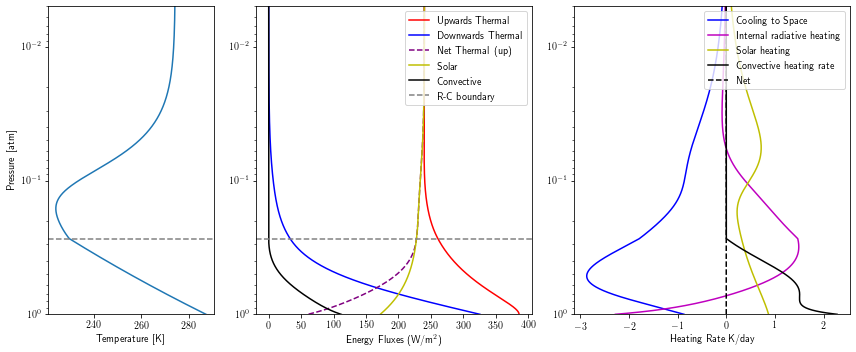

In [7]:
earth = Solve(earth, freevar = 'taurcT0')
earth = AddFluxes(earth)
PlotScenario(earth, title = 'Earth')

Negative tau0 or taurc.
Negative tau0 or taurc.
Negative tau0 or taurc.
Negative tau0 or taurc.
Negative tau0 or taurc.


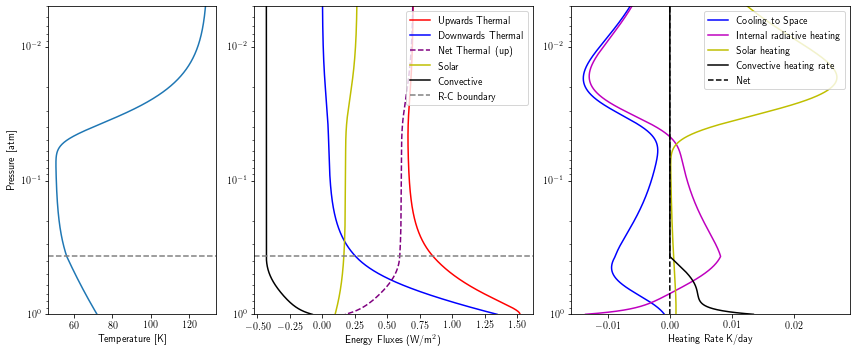

In [8]:
neptune = Solve(neptune, freevar = 'taurcT0')
neptune = AddFluxes(neptune)
PlotScenario(neptune, title = 'Neptune')

## (5) Problems

#### (5a) The model doesn't match the Earth's stratospheric profile.

I am currently unclear whether this is a bug in how the model is implemented here or a feature of the approximation.

In [9]:
data_directory = ''
                      
def standard_column(path = 'us_stand.dat'):
    """
    Imports the standard column used to augment the climate model data
    where it does not extend.
    """
    usstd = np.loadtxt(path, comments='#')

    # Convert to our column format. # TODO: Fix so returns correct units
    col_info = {
        'lat': 0,
        'lon': 0,
        'time': 0,
        'source': 'US Std Atm',
        
        'z': usstd[:, 0],  # z(km) -> zkm

        'pressure': usstd[:, 1]*100,  # p(mb) -> Pa
        'T': usstd[:, 2],  # T(K) - > K

        'density': usstd[:, 3]  * 29 * 10**-3 * 10 ** 6 / const.N_A,  # air 'density' (cm-3) -> kg/m^3
        'O3': usstd[:, 4]  * 10 ** 6 / const.N_A,  # o3(cm-3) -> mol/m^3
        'O2': usstd[:, 5] * 10 ** 6 / const.N_A,  # o2(cm-3) -> mol/m^3
        'H2O': usstd[:, 6] * 10 ** 6 / const.N_A,  # h2o(cm-3) -> mol/m^3
        'CO2': usstd[:, 7] * 10 ** 6 / const.N_A,  # co2(cm-3) -> mol/m^3
        'NO2': usstd[:, 8]  * 10 ** 6 / const.N_A # no2(cm-3) -> mol/m^3
        }

    return col_info

stdcol = standard_column(data_directory + 'us_stand.dat')

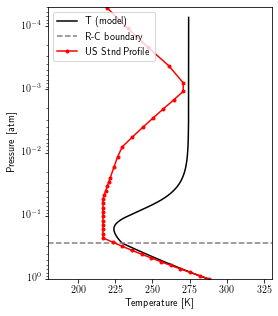

In [10]:
f, (ax1) = plt.subplots(1, 1, figsize=(4, 5))

scale_height = 8.5
earth['z'] = -scale_height * np.log(earth['p']/earth['p0'])
C = earth

plt.plot(C['T'], C['p'], 'k', label = 'T (model)')
ax1.set_ylim([C['p0'],0.00005])
ax1.set_xlabel('Temperature [K]')
ax1.set_ylabel('Pressure [atm]')
ax1.set_yscale('log')
ax1.axhline(C['p_rc'], color = 'grey', linestyle = 'dashed', label = 'R-C boundary')


ax1.plot(stdcol['T'], stdcol['pressure']/101325, '.-r', label = 'US Stnd Profile')
ax1.set_xlim([180, 330])
ax1.legend()


#### (5b) The model doesn't converge for Venus.

In [11]:
venus = Solve(venus, freevar = 'taurcT0')

Negative tau0 or taurc.
Negative tau0 or taurc.


/Users/g/miniconda3/envs/entropyPhD/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


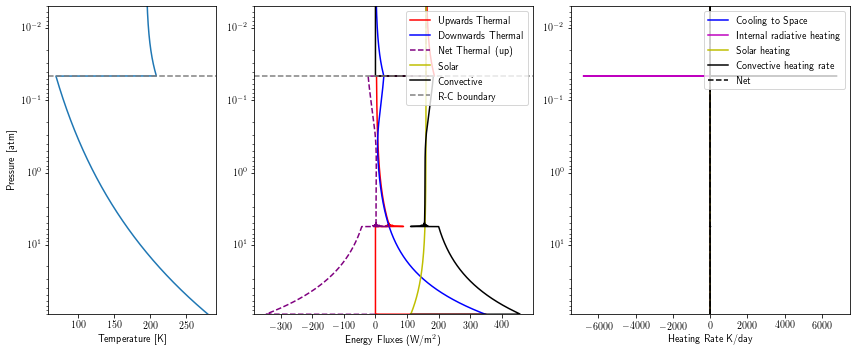

In [12]:
venus = AddFluxes(venus)
PlotScenario(venus, title = 'Venus')